### Load clean_dataset we used for baseline:

In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("cleaned_dataset.csv")

# Display basic info (optional)
print(df.columns)  # Make sure you know the column names
print(f"Total entries: {len(df)}")

# Print a random or specific example (assuming column name is 'summary')
example_summary = df.loc[0, 'Summary']
# example_summary = df.sample(1)['Summary'].values[0] # for random row
print("Example Summary:")
print(example_summary)

Index(['URL', 'Content', 'Summary', 'Sentiment'], dtype='object')
Total entries: 26233
Example Summary:
consumer spending plunges 13.6 percent in april. that was the biggest drop since the government started tracking series in 1959. consumer spending accounts for more than two-thirds of economic activity. economists polled by reuters had forecast consumer spending plummeting 12.6 percent. a spokesman for the u.s. government said the data was not available.


### Required Libraries Needed:

In [43]:
'''
pip install keybert
pip install sentence-transformers
pip install nltk
pip install requests pillow imagehash
pip install git+https://github.com/openai/CLIP.git
'''

'\npip install keybert\npip install sentence-transformers\npip install nltk\npip install requests pillow imagehash\n'

### 1. Keyword Extraction

**Overview**: First, we need to extract meaningful keywords or phrases from the summary. We will be using KeyBERT(pretrained) to extract high-quality keywords or phrases from each sentence/summary. This will give us more context-relevant keywords/phrases instead of words that have the highest occurrence across the text.

#### Load the pretrained model:

In [29]:
from keybert import KeyBERT

# Load the model (based on 'all-MiniLM-L6-v2' by default)
kw_model = KeyBERT()

# Example usage:
summary = "The company reported a 15% increase in revenue this quarter, driven by strong sales in the technology sector."

keywords = kw_model.extract_keywords(summary, top_n=5, stop_words='english') # Extract keywords

print(keywords)

[('revenue', 0.4526), ('increase', 0.3737), ('sales', 0.3573), ('sector', 0.3096), ('company', 0.2703)]


The number beside the keyword is the **relevance score** that reflects how semantically important or representative that keyword is to the input text, based on embeddings.

#### Extract keywords across the entire cleaned dataset summary:

In [19]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() # we apply the lemmatizer to filter out plural duplicates of the keywords

top_keywords = []
seen = set() # we use set to find unique keywords only because it's faster
          
for summary in df['Summary']:
    keywords = kw_model.extract_keywords(summary, top_n=2, stop_words='english')
    
    for kw in keywords:
        keyword = kw[0].lower()  # kw = (keyword, score)
        lemma = lemmatizer.lemmatize(keyword) # normalize + lemmatize
        
        if lemma not in seen:
            seen.add(lemma)
            top_keywords.append(lemma)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qq258\AppData\Roaming\nltk_data...


In [20]:
print("There are",len(top_keywords), "unique keywords.")

There are 4550 unique keywords.


In [21]:
# first 30 keywords as example
for i in range(10):
    print(top_keywords[i*3],",",top_keywords[i*3+1],",",top_keywords[i*3+2])

spending , consumer , fiscal
deficit , exporter , export
dollar , tariff , angel
bond , index , covid
pandemic , lockdown , manmohan
bjp , fiis , investor
fine , cartel , jio
jiophone , price , lng
nonfarm , payroll , muhurat
diwali , television , coronavirus


In [26]:
# we will save those keywords so we dont have to run the code every time
'''
with open("top_keywords.txt", "w") as f:
    for keyword in top_keywords:
        f.write(keyword + "\n")
'''

'\nwith open("top_keywords.txt", "w") as f:\n    for keyword in top_keywords:\n        f.write(keyword + "\n")\n'

In [1]:
# if we need to load it next time below is the code

with open("top_keywords.txt", "r") as f:
    top_keywords = [line.strip() for line in f]


In [2]:
print(len(top_keywords))

4550


With enough keywords, we can start to create the local image dataset we need.

### 2. Local Image Dataset

**Overview**: We need a much larger image database than we had for the baseline(100 images). This time, we will download around 5k images from license-free sources(Unsplash, Pexels) based on the extracted keywords we got earlier. We will label(name) the images by the keywords we used to search for each of them. 

Both Pexels and Unsplash limit the number of search requests per hour; Pexels being 200/hr, and Unsplash being 50/hr. Therefore, our strategy is to download as many photos using the Pexels api first, then we will use the Unsplash api to download the remaining photos of the missed keyword that could not be found in Pexels.

We will save the missed keywords in a .txt file.

In [3]:
# Load missed keywords
with open("missed_keywords.txt", "r") as f:
    missed_keywords = [line.strip() for line in f]

To avoid downloading the same photo for different keywords (the problem we encounter in baseline due to the small photo database in Pexels), we will use imagehash to check the uniqueness of the photo before we download them.

In [5]:
import imagehash
import requests, os

HASH_FILE = "seen_hashes.txt"

# Load saved hashes from file
def load_hashes():
    if not os.path.exists(HASH_FILE):
        return set()
    with open(HASH_FILE, 'r') as f:
        return set(line.strip() for line in f)

# Append a new hash to file
def save_hash(img_hash):
    with open(HASH_FILE, 'a') as f:
        f.write(f"{str(img_hash)}\n")

seen_hashes = load_hashes()

def is_unique_image(img_bytes):
    try:
        img = Image.open(BytesIO(img_bytes)).convert('RGB')
        img_hash = imagehash.phash(img)
        if str(img_hash) in seen_hashes:
            return False
        seen_hashes.add(str(img_hash))
        save_hash(img_hash)  # persist it
        return True
    except Exception as e:
        print("Hashing failed:", e)
        return False

#### Image Retrieval function(for both PEXELS and UNSPLASH api:

In [71]:
import requests, os, time
from PIL import Image
from io import BytesIO

PEXELS_SEARCH_URL = "https://api.pexels.com/v1/search"
UNSPLASH_SEARCH_URL = "https://api.unsplash.com/search/photos"
SEARCH_RESULTS_PER_QUERY = 15  # 15 imgs/search to make sure we get the unique photo

PEXELS_KEYS = [
    "3OisFzBYYJVYd0Gv6Eb75SGSblyEfKSTX0mls3CpAImHIYpEBhR9KR9W",
    "O88sCtvbUVt0aqVowgiYMVY3uyagzmYZFuCaXTDI8ZxKKbpNlUQvZ9Ds"
]

UNSPLASH_KEYS = [
    "WiSPzm8sLPsTo3XHc9TsGjNJ__NMNB3s373Jkb06i9A",
    "y4zjPKbnioj619Z0GBhyw1Q9CrJZhuHaJQPkcJvdbts",
    "RnfZIgHyka6V4ZJaEK6f5lmXs82acjvbEeo74BlmzfA",
    "hnJqymFHMbFGxSO9CQAaEilRuop5uUQEq6J2snVJRpA",
    "FZp2R8JSj2CPj0jHHuq5Y-0lF3zgw2juTzV4TVg6rtU",
    "KCBEfPLbOb8CPWxlkYi86P2fHl8EoUbR3nNCLBgB1Mw",
    "eWM2lGqhUK1q5uUhlTiDExfxRJhRJRyerkAaTxEr1Fs",
    "XtVJ4RgRHRaOqe8O6YdUPW1v64e48eXUEunJfxF39Oc",
    "JFbb9NxW84i6N6hcUMLnzqJ5sgdb7k-BmnsaGBIc3GI",
    "2QX6clYKb89gc5kfy01A6laclGQDI3qMJCeqZlb5F9s",
    "Utkw4GZxqPIbT6cpIZ4BP39XDGTIsdelAVgXtESlUhk",
    "FG_kQ9263GiCAA7J1s-LQHl88g5USLz5eRGz9Es-c4I",
    "Lg-CuJfocBffp83kgHQcgMspSGy2t4pLm1_188yjMHM",
    "n5YuimsCLlTGf5tocPzjLrlcQXmqtA_iW7JabYLuj2w"
]

def retrieval_images(website, keywords, output_dir="clip_images"):
    os.makedirs(output_dir, exist_ok=True)
    counter = 0

    def try_download(web, search_query, access_key):
        if web == "pexels":
            headers = {
                "Authorization": access_key
            }
        elif web == "unsplash":
            headers = {
                "Authorization": f"Client-ID {access_key}"
            }
        params = {
            "query": search_query,
            "per_page": SEARCH_RESULTS_PER_QUERY
        }
        if web == "pexels":
            response = requests.get(PEXELS_SEARCH_URL, headers=headers, params=params)
        elif web == "unsplash":
            response = requests.get(UNSPLASH_SEARCH_URL, headers=headers, params=params)
        #time.sleep(4)
        if response.status_code != 200:
            raise RuntimeError(f"API error {response.status_code} for query: {search_query}")
            return False
            
        if web == "pexels":
            results = response.json().get("photos", [])
        elif web == "unsplash":
            results = response.json().get("results", [])
            
        for result in results:
            if web == "pexels":
                img_url = result["src"]["large"]
            elif web == "unsplash":
                img_url = result["urls"]["regular"]
            img_data = requests.get(img_url).content
            time.sleep(0.2)

            if is_unique_image(img_data):
                filepath = os.path.join(output_dir, f"{search_query.split()[0]}.jpg")
                with open(filepath, 'wb') as f:
                    f.write(img_data)
                print(search_query.split()[0], f"is downloaded (query: '{search_query}')")
                return True
        return False

    for keyword in keywords:
        filepath = os.path.join(output_dir, f"{keyword}.jpg")
        if os.path.exists(filepath):
            continue
        if website == "pexels":
            current_key = PEXELS_KEYS[counter % len(PEXELS_KEYS)]
        elif website == "unsplash":
            current_key = UNSPLASH_KEYS[counter % len(UNSPLASH_KEYS)]
        
        try:
            found_unique = try_download(website, f"{keyword} finance", current_key)
            if not found_unique:
                print(f"Retrying keyword-only search for: {keyword}")
                found_unique = try_download(website, keyword, current_key)
            if not found_unique:
                missed_keywords.append(keyword)
                print(f"No unique image found for: {keyword}")

        except Exception as e:
            print(f"Stopped due to error: {e}")
            break
        counter += 1

    # Save missed keywords
    with open("missed_keywords.txt", "w") as f:
        for kw in missed_keywords:
            f.write(f"{kw}\n")

    print("Download finished!")
    print("Missed keywords saved to missed_keywords.txt")

Below is a demonstration of how we use the retrieval_image function to download the images with a smaller keyword list.

In [28]:
keyw = []
for i in range(100):
    keyw.append(top_keywords[4450+i])

retrieval_images("pexels", keyw)

ford is downloaded (query: 'ford finance')
Retrying keyword-only search for: letsgetindiaticking
No unique image found for: letsgetindiaticking
Retrying keyword-only search for: ujjwala
No unique image found for: ujjwala
Retrying keyword-only search for: kridn
No unique image found for: kridn
Retrying keyword-only search for: aca
aca is downloaded (query: 'aca')
Retrying keyword-only search for: enrollment
enrollment is downloaded (query: 'enrollment')
Retrying keyword-only search for: leapp
leapp is downloaded (query: 'leapp')
Retrying keyword-only search for: wef
wef is downloaded (query: 'wef')
Retrying keyword-only search for: tesaro
No unique image found for: tesaro
cricket is downloaded (query: 'cricket finance')
tournament is downloaded (query: 'tournament finance')
Retrying keyword-only search for: moderna
moderna is downloaded (query: 'moderna')
Retrying keyword-only search for: negotiator
negotiator is downloaded (query: 'negotiator')
antigua is downloaded (query: 'antigua fi

After reviewing the entire keyword list with Pexels' API, we identified 1278 keywords that are not present on the website.

In [9]:
print(len(missed_keywords))
print(missed_keywords)

1278
['rebalancing', 'microcredit', 'privatisation', 'surjewala', 'drungmaker', 'gnpas', 'deactivate', 'aditya', 'mmbtu', 'gcmmf', 'delhiites', 'nowrosjee', 'bsvi', 'kundya', 'neoliberal', 'grubhub', 'hpcl', 'marketcap', 'dd', 'canararobeco', 'sinologist', 'lokhandwala', 'patwari', 'siddaramaiah', 'weightage', 'mariwala', 'airdots', 'rathnam', 'financialisation', 'sgbs', 'slippage', 'legalised', 'grievance', 'moneycontrol', 'q1fy21e', 'n100', 'ccea', 'xinfadi', 'mindtree', 'reclassification', 'amfi', 'ukibc', 'aamir', 'mahakootami', 'byju', 'dgca', 'hfc', 'pewdiepie', 'iqube', 'publicis', 'starcom', 'bagadia', '650hp', 'kushner', 'jared', 'glargine', 'zoomcar', 'sharechat', 'jugnoo', 'cccs', 'fsdc', 'dzire', 'hmcl', 'cxos', 'largecap', 'iiml', 'nihilist', 'separatist', 'crpc', 'mncs', 'ncdex', 'lucchini', 'staqu', 'xennials', 'qibs', 'mypedia', '000mah', 'mclrs', 'mehra', 'jiomart', 'oversupply', 'sarokar', 'shiddat', 'balkrishna', 'aatmanirbharta', 'aatmanirbhar', 'weaponised', 'chemo

Now we will use Unsplash's API to download the missed keywords, as they have a much larger photo base.

In [ ]:
retrieval_images("unsplash", missed_keywords)

Retrying keyword-only search for: gencos
gencos is downloaded (query: 'gencos')
Retrying keyword-only search for: debenture
debenture is downloaded (query: 'debenture')
recapitalisation is downloaded (query: 'recapitalisation finance')
Retrying keyword-only search for: downgrade
downgrade is downloaded (query: 'downgrade')
Retrying keyword-only search for: ndrf
No unique image found for: ndrf
bs6 is downloaded (query: 'bs6 finance')
Retrying keyword-only search for: bs4
bs4 is downloaded (query: 'bs4')
Retrying keyword-only search for: aibea
aibea is downloaded (query: 'aibea')
Retrying keyword-only search for: nonbank
nonbank is downloaded (query: 'nonbank')
Retrying keyword-only search for: icmr
icmr is downloaded (query: 'icmr')
Retrying keyword-only search for: reinsurers
reinsurers is downloaded (query: 'reinsurers')
milkbasket is downloaded (query: 'milkbasket finance')
Retrying keyword-only search for: manappuram
manappuram is downloaded (query: 'manappuram')
Retrying keyword-on

In [69]:
# Load missed keywords
with open("missed_keywords.txt", "r") as f:
    missed_keywords = [line.strip() for line in f]

In [5]:
print(len(missed_keywords))

7


Now we have successfully obtained the large database we want, except for only 7 keywords(out of 4550)! After checking them out manually, most of them are the company name, so we will keep them out of our photo database.

### 3. Encode(index) the Images

**Overview**: We will use the pretrained OpenAI Clip model to encode each images using CLIP's image_encoder, and encode the corresponding keyword/caption using CLIP's text_encoder, this way we can store the image embeddings in a local vector database.

In [6]:
import os
import torch
import clip
from PIL import Image
import numpy as np

# Load CLIP model (ViT-B/32)
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
# image directory
image_dir = "clip_images"
image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]

# Store embeddings and filenames
image_embeddings = []
image_keywords = []

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    try:
        image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model.encode_image(image)
            embedding = embedding / embedding.norm(dim=-1, keepdim=True)  # normalize
        image_embeddings.append(embedding.cpu())
        image_keywords.append(img_file.split(".")[0])  # Use filename (or parse as needed)
    except Exception as e:
        print(f"Failed to process {img_file}: {e}")

# Stack all embeddings into a matrix
image_embeddings = torch.cat(image_embeddings)

# Save embeddings and keywords
torch.save({"embeddings": image_embeddings, "keywords": image_keywords}, "clip_image_index.pt")

print(f"Encoded {len(image_embeddings)} images and saved to clip_image_index.pt")


100%|███████████████████████████████████████| 338M/338M [00:48<00:00, 7.37MiB/s]


Encoded 4541 images and saved to clip_image_index.pt


Now we've got everything we need! below is how we can apply those to any summaries given:

### Image Retrieval with any summary/keywords given

We will be using **cosine similarity** to find matching images with a given query in the embedding space. The function **search_clip_images(query, top_k)** takes in a summary text, and outputs a ranked list of the most semantically similar images to the query given. We will also use **KeyBERT** to extract keywords from the summary before sending it to the search_clip_image function if the summary gets too long, because CLIP uses a maximum token length of 77 tokens, and any text exceeding that limit will raise a runtime error.

In [2]:
import torch
import clip
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load image embeddings and keywords
data = torch.load("clip_image_index.pt", map_location=device)
image_embeddings = data["embeddings"]
image_keywords = data["keywords"]

In [3]:
from keybert import KeyBERT

kw_model = KeyBERT()

def extract_keywords(text, top_n=5):
    keywords = kw_model.extract_keywords(text, top_n=top_n, stop_words='english')
    return [kw for kw, score in keywords]

D:\Anaconda3\Anac3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
from sklearn.metrics.pairwise import cosine_similarity

def search_clip_images(query, top_k):
    with torch.no_grad():
        text = clip.tokenize([query]).to(device)
        text_embedding = model.encode_text(text)
        text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)

    similarities = cosine_similarity(
        text_embedding.cpu().numpy(), image_embeddings.cpu().numpy())[0]

    # Get top-k indices
    top_k_indices = np.argsort(similarities)[::-1][:top_k]
    
    results = [(image_keywords[i], similarities[i]) for i in top_k_indices]
    return results

In [30]:
def image_retrieval(summary, top_keywords=5):
    try:
        # if under limit we can directly use clip
        results = search_clip_images(summary, top_keywords)
    except RuntimeError as e: # otherwise it will raise a flag
        if "too long for context length" in str(e):
            # Fallback to keyword-based retrieval with KeyBART
            keywords = extract_keywords(summary, top_keywords)
            results = []
            for kw in keywords:
                results.extend(search_clip_images(kw,1))
        else:
            raise e  # propagate unexpected errors
    return results

In [38]:
import matplotlib.pyplot as plt
from PIL import Image

def display_images_side_by_side(results, max_images=5):
    # Set up figure
    fig, axes = plt.subplots(1, max_images, figsize=(20, 5))  # 1 row, 5 columns

    for i, (keyword, score) in enumerate(results[:max_images]):
        img_path = f"clip_images/{keyword}.jpg"
        image = Image.open(img_path)
        
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"{keyword}\n(score: {score:.4f})")

    plt.tight_layout()
    plt.show()

In [39]:
query = "stock market crash"
results = image_retrieval(query)

for keyword, score in results:
    print(f"{keyword} (score: {score:.4f})")

cimsme (score: 0.2810)
burzin (score: 0.2750)
infected (score: 0.2747)
nasdaq (score: 0.2732)
income (score: 0.2726)


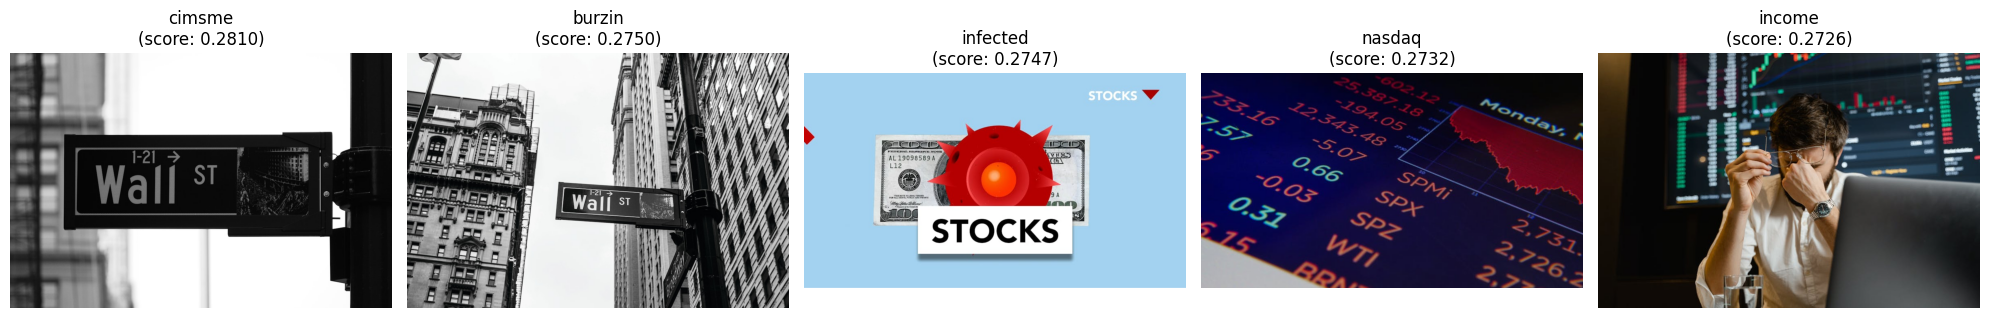

In [40]:
display_images_side_by_side(results)

In [42]:
# now we will try an example from the clean dataset:
print(example_summary)

results2 = image_retrieval(example_summary,5)

for keyword, score in results:
    print(f"{keyword} (score: {score:.4f})")

consumer spending plunges 13.6 percent in april. that was the biggest drop since the government started tracking series in 1959. consumer spending accounts for more than two-thirds of economic activity. economists polled by reuters had forecast consumer spending plummeting 12.6 percent. a spokesman for the u.s. government said the data was not available.
cimsme (score: 0.2810)
burzin (score: 0.2750)
infected (score: 0.2747)
nasdaq (score: 0.2732)
income (score: 0.2726)


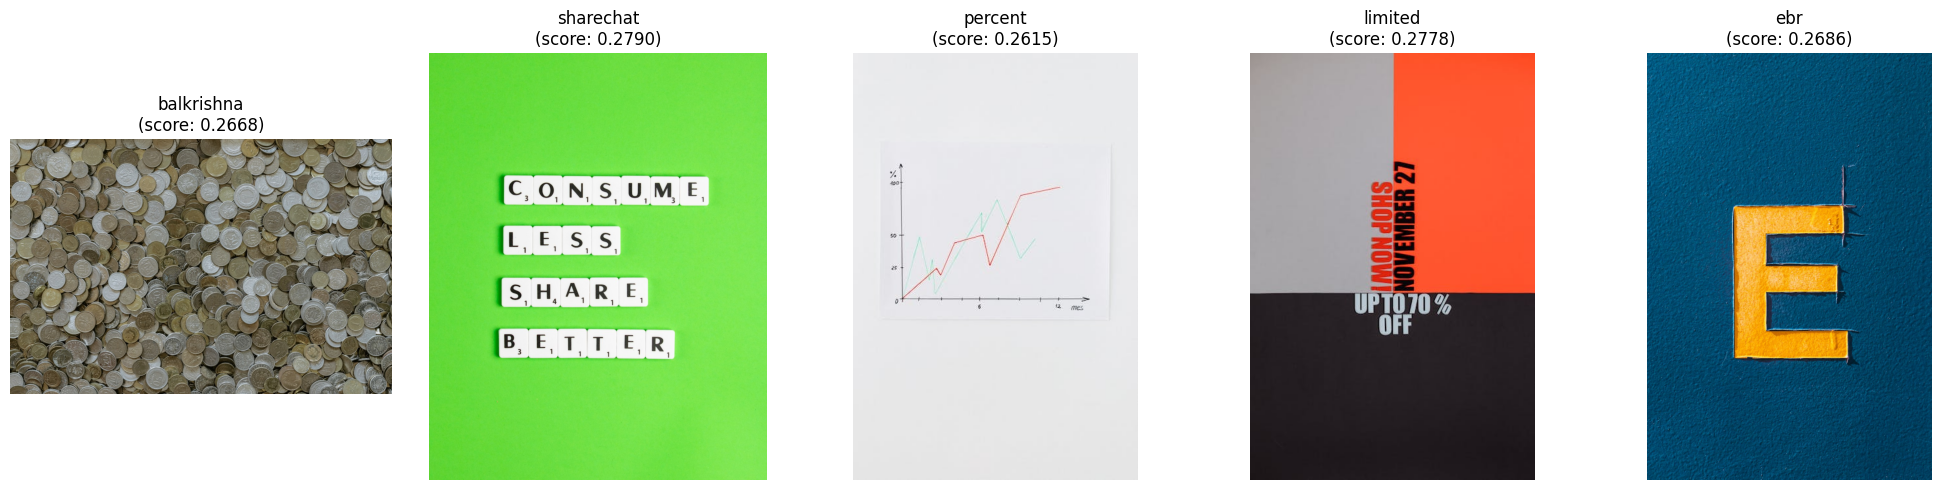

In [43]:
display_images_side_by_side(results2)

With **image_retrieval(summary, top_keywords)** and **display_images_side_by_side(results)**, we can now output retrieved images based on the summary given, without worrying about the length of the summary.

If you want to test it, do the following:

**- Load image embeddings and keywords(run the code below)**

**- results = image_retrieval(example_summary,number_of_output_images)**

**- display_images_side_by_side(results)**

In [45]:
'''
import torch
import clip
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load image embeddings and keywords
data = torch.load("clip_image_index.pt", map_location=device)
image_embeddings = data["embeddings"]
image_keywords = data["keywords"]
'''

'\nimport torch\nimport clip\nimport numpy as np\n\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\nmodel, preprocess = clip.load("ViT-B/32", device=device)\n\n# Load image embeddings and keywords\ndata = torch.load("clip_image_index.pt", map_location=device)\nimage_embeddings = data["embeddings"]\nimage_keywords = data["keywords"]\n'